# Price-Based Control

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']
energy_price_series = df['Agile Import price (p/kWh)']

In [3]:
# Function to calculate heat loss
def calculate_heat_loss(K, indoor_temp, outdoor_temp):
    return K * (indoor_temp - outdoor_temp)

In [4]:
# Calculate the low and high price thresholds
energy_price_max = 67.68
energy_price_min = -19.03

low_price_threshold = energy_price_min + 0.3 * (energy_price_max - energy_price_min)
high_price_threshold = energy_price_min + 0.75 * (energy_price_max - energy_price_min)

In [5]:
# Define system parameters
desired_indoor_temp_low = 18
desired_indoor_temp_medium = 20.0  # Desired indoor temperature in °C
desired_indoor_temp_high = 22.0  # Desired indoor temperature in °C

# # Pricing tiers (values in p/kWh)
# low_price_threshold = 10
# high_price_threshold = 30

# Time step in hours
delta_t = 0.5

# Heat loss coefficient
K_SH = 0.07

# Building conditions
rho_in = 1.2041  # Air density in kg/m^3
c_in = 1000      # Specific heat capacity of air in J/(kg*K)
V_in = 3277      # Volume of the building in m^3

In [6]:
# Initialize variables
indoor_temp = 20  # Start with indoor temperature
heat_demand_profile = []
heat_loss_profile = []
flow_temp_series = []
heat_pump_status = []
indoor_temp_series = []

# Control strategy simulation loop over time
for t in range(len(energy_price_series)):
    outdoor_temp = outdoor_temp_series[t]
    energy_price = energy_price_series[t]
    
    if energy_price >= high_price_threshold:
        indoor_temp_series.append(indoor_temp)
        desired_indoor_temp = desired_indoor_temp_low
        if outdoor_temp >= desired_indoor_temp:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp = desired_indoor_temp
            # indoor_temp_series.append(indoor_temp)
        elif indoor_temp <= desired_indoor_temp:
            heat_pump_status.append("On")
            heat_demand = (calculate_heat_loss(K_SH, desired_indoor_temp, outdoor_temp) + ((desired_indoor_temp - indoor_temp) * rho_in * V_in * c_in)/3.6e6)/delta_t
            indoor_temp = desired_indoor_temp
        else:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp -= (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)*3.6e6)/(rho_in*V_in*c_in)
        
    elif energy_price > low_price_threshold and energy_price < high_price_threshold:
        indoor_temp_series.append(indoor_temp)
        desired_indoor_temp = desired_indoor_temp_medium
        if outdoor_temp >= desired_indoor_temp:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp = desired_indoor_temp
            # indoor_temp_series.append(indoor_temp)
        elif indoor_temp <= desired_indoor_temp:
            heat_pump_status.append("On")
            heat_demand = (calculate_heat_loss(K_SH, desired_indoor_temp, outdoor_temp) + ((desired_indoor_temp - indoor_temp) * rho_in * V_in * c_in)/3.6e6)/delta_t
            indoor_temp = desired_indoor_temp
        else:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp -= (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)*3.6e6)/(rho_in*V_in*c_in)
    elif energy_price <= low_price_threshold:
        indoor_temp_series.append(indoor_temp)
        desired_indoor_temp = desired_indoor_temp_high
        if outdoor_temp >= desired_indoor_temp:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp = desired_indoor_temp
            # indoor_temp_series.append(indoor_temp)
        elif indoor_temp <= desired_indoor_temp:
            heat_pump_status.append("On")
            heat_demand = (calculate_heat_loss(K_SH, desired_indoor_temp, outdoor_temp) + ((desired_indoor_temp - indoor_temp) * rho_in * V_in * c_in)/3.6e6)/delta_t
            indoor_temp = desired_indoor_temp
        else:
            heat_pump_status.append("Off")
            heat_demand = 0
            indoor_temp -= (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)*3.6e6)/(rho_in*V_in*c_in)
    
    heat_demand_profile.append(heat_demand)
        
 

In [7]:
# Create a DataFrame for visualization
simulation_data = pd.DataFrame({
    "Date": df['Date'],
    "Outdoor Temperature (°C)": outdoor_temp_series,
    "Indoor Temperature (°C)": indoor_temp_series,
    "Energy Price (p/kWh)": energy_price_series,
    "Heat Demand (kW)": heat_demand_profile,
    "Heat Pump Status": heat_pump_status
})

In [8]:
simulation_data['Heat Demand (kWh)'] = simulation_data['Heat Demand (kW)'] * delta_t
simulation_data.to_csv("simulation_results_price.csv", index=False)

In [9]:
np.sum(simulation_data['Heat Demand (kWh)'])

np.float64(14779.589681255648)

# Visualisation

In [10]:
simulation_data['Date'] = pd.to_datetime(simulation_data['Date'], format='%Y-%m-%d %H:%M:%S')
simulation_data.set_index('Date', inplace=True)

In [11]:
simulation_data.head()

,Outdoor Temperature (°C),Indoor Temperature (°C),Energy Price (p/kWh),Heat Demand (kW),Heat Pump Status,Heat Demand (kWh)
Date,,,,,,
2023-01-01 00:00:00,5.5,20.000000,4.41,6.694262,On,3.347131
2023-01-01 00:30:00,5.5,22.000000,13.91,0.000000,Off,0.000000
2023-01-01 01:00:00,5.5,20.946231,15.44,0.000000,Off,0.000000
2023-01-01 01:30:00,5.5,19.959760,1.10,6.782472,On,3.391236
2023-01-01 02:00:00,5.5,22.000000,6.70,2.310000,On,1.155000


## Annual half hourly profile

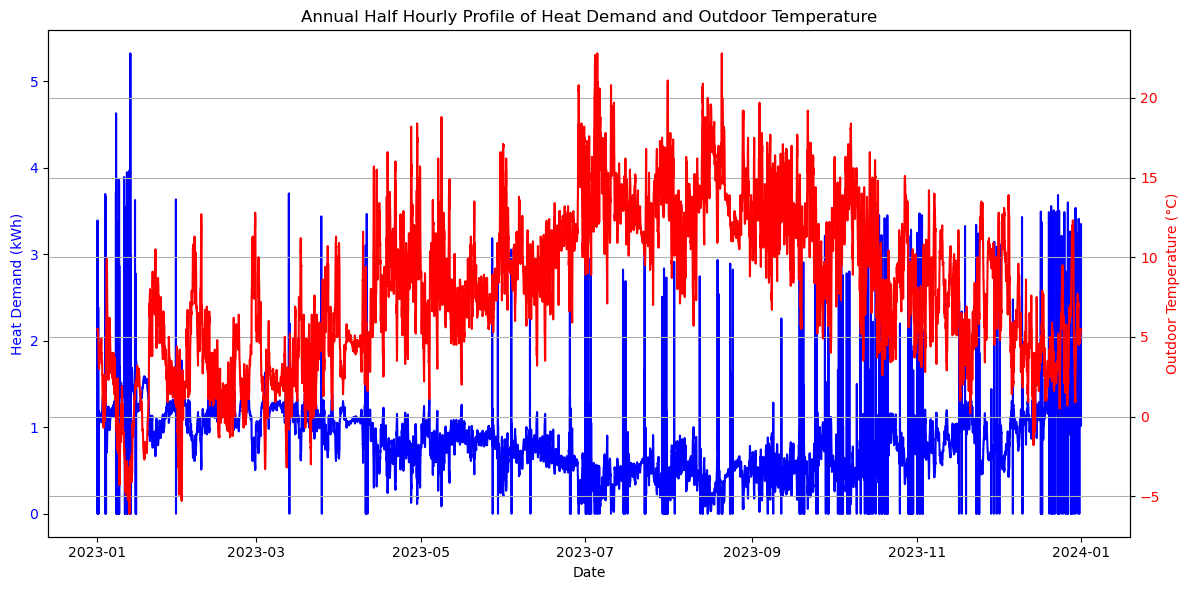

In [12]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(simulation_data.index, simulation_data['Heat Demand (kWh)'], label='Half Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(simulation_data.index, simulation_data['Outdoor Temperature (°C)'], label='Half Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Half Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_half_hourly_profile_price.pdf')
plt.show()

## Annual hourly profile

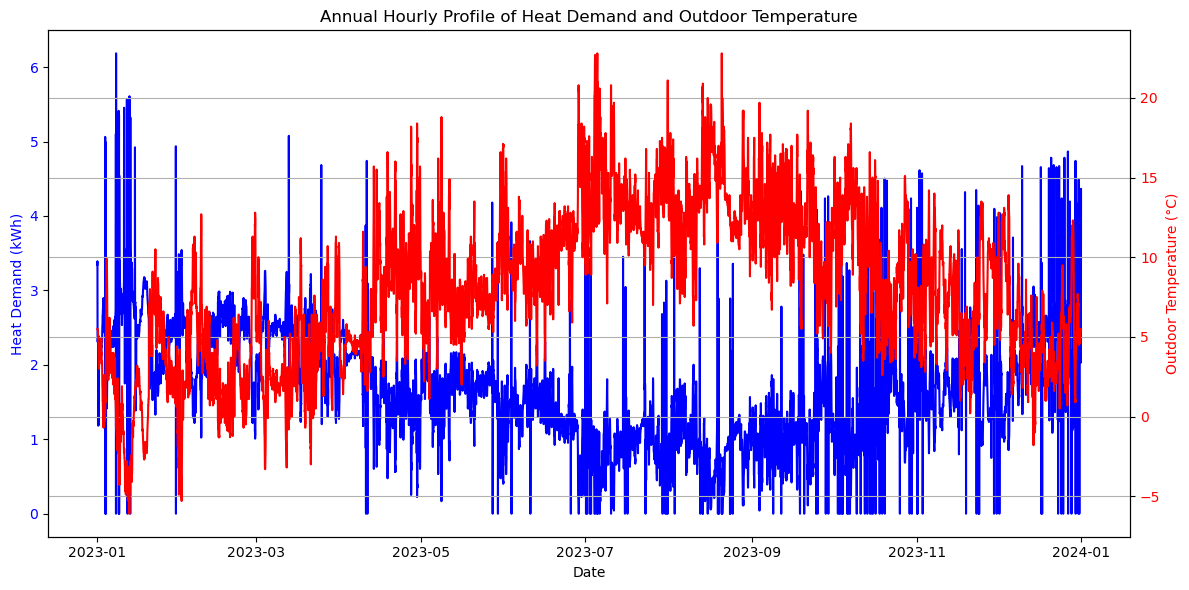

In [13]:
# Resample to hourly frequency and calculate the sum of heat demand and average outdoor temperature
hourly_df = simulation_data["Heat Demand (kWh)"].resample('h').sum().to_frame()
hourly_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('h').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(hourly_df.index, hourly_df['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_df.index, hourly_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_hourly_profile_price.pdf')
plt.show()

## Daily hourly profile

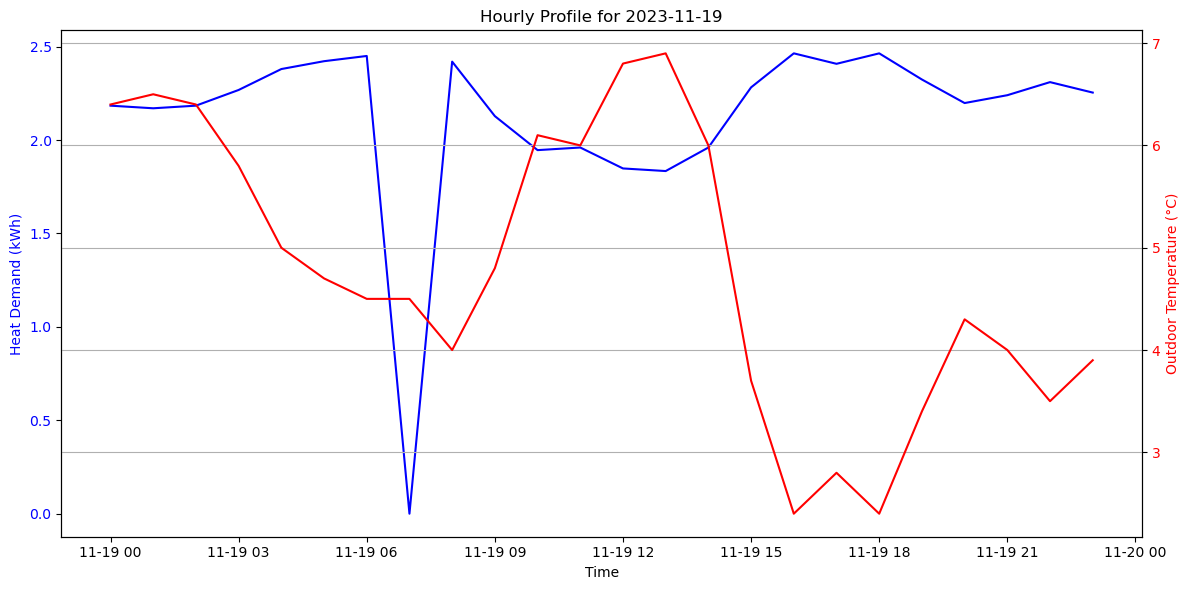

In [14]:
# Specify the day you want to plot
specific_day = '2023-11-19'  # Change this to the desired date

# Filter the data for the specific day
daily_profile = hourly_df.loc[specific_day]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(daily_profile.index, daily_profile['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_profile.index, daily_profile['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Hourly Profile for {specific_day}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/hourly_profile_{specific_day}_price.pdf')
plt.show()

## Annual daily profile

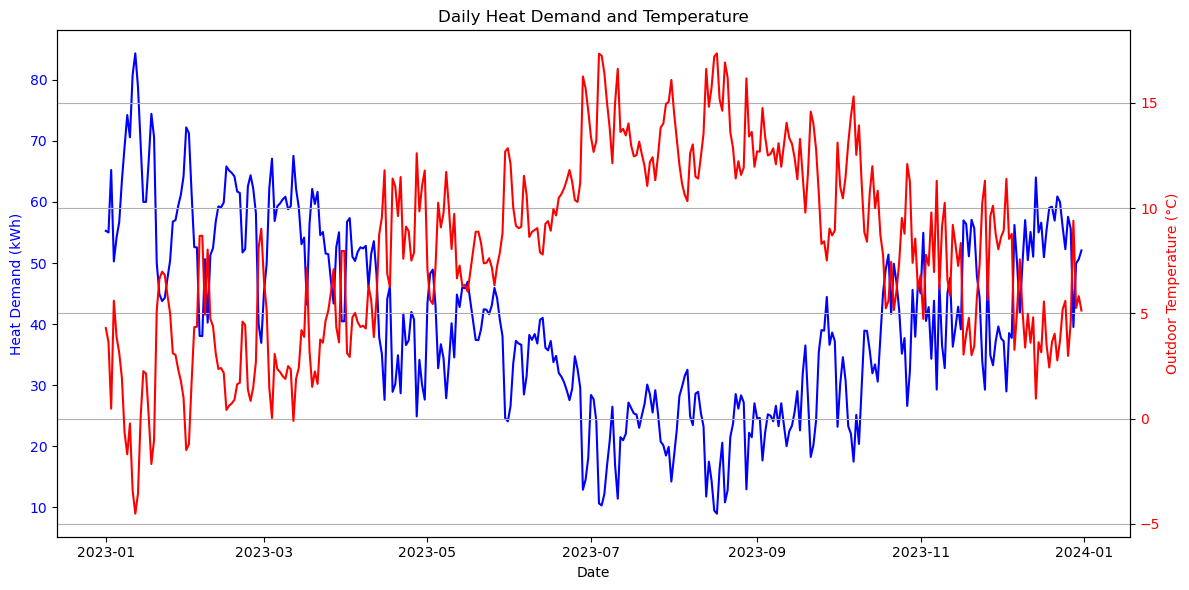

In [15]:
# Resample to daily frequency and calculate the sum of heat demand and average outdoor temperature
daily_df = simulation_data["Heat Demand (kWh)"].resample('D').sum().to_frame()
daily_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(daily_df.index, daily_df['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Daily Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_daily_profile_price.pdf')
plt.show()

## Monthly daily profile

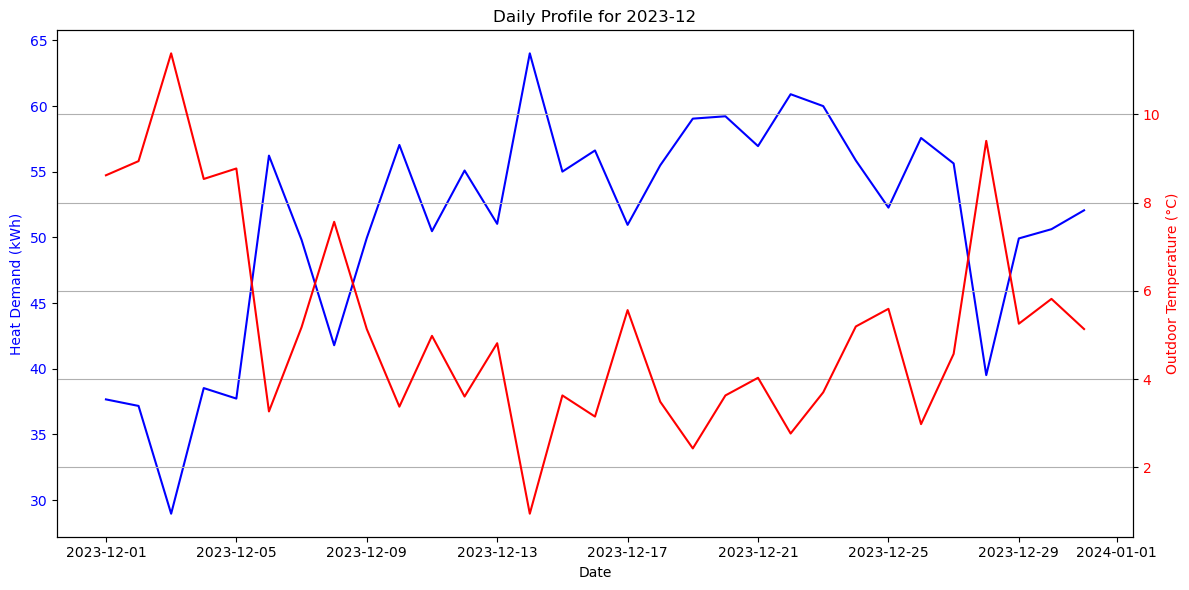

In [16]:
# Specify the month you want to plot
specific_month = '2023-12'  # Change this to the desired month

# Filter the data for the specific month
monthly_profile = daily_df.loc[specific_month]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(monthly_profile.index, monthly_profile['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_profile.index, monthly_profile['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Daily Profile for {specific_month}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/monthly_profile_{specific_month}_price.pdf')
plt.show()

## Annual monthly profile

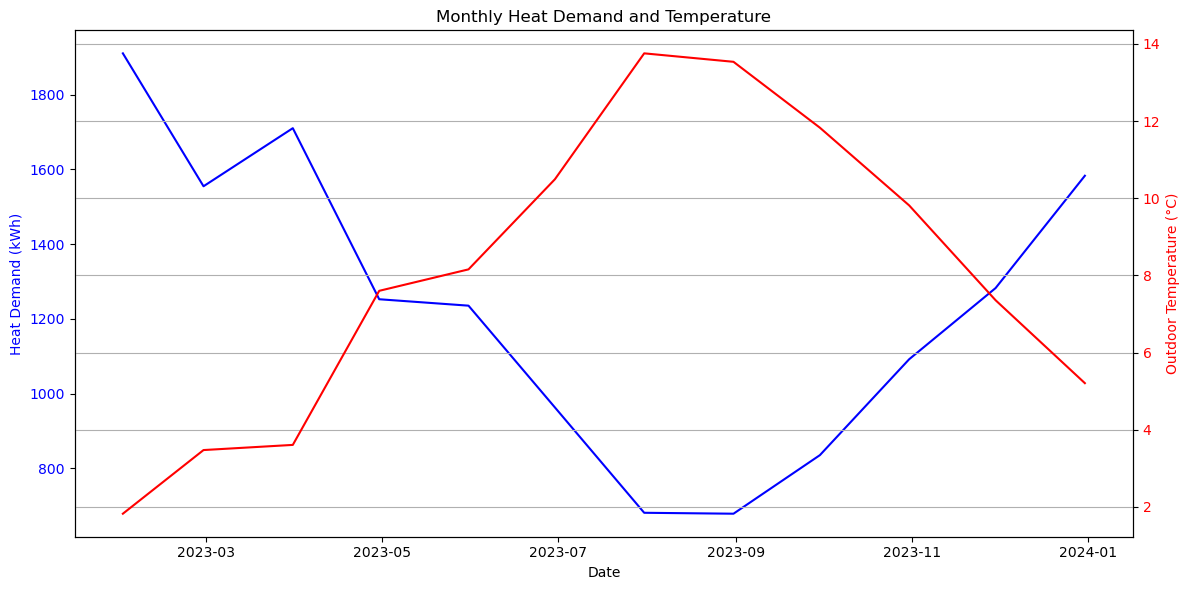

In [17]:
# Resample to daily frequency and calculate the sum of heat demand and average outdoor temperature
monthly_df = simulation_data["Heat Demand (kWh)"].resample('ME').sum().to_frame()
monthly_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('ME').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(monthly_df.index, monthly_df['Heat Demand (kWh)'], label='Monthly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_df.index, monthly_df['Outdoor Temperature (°C)'], label='Monthly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Monthly Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_monthly_profile_price.pdf')
plt.show()